# Variational Inference and Markov Chain Monte Carlo

Special credits to Doug for the code stub and several instances of text.

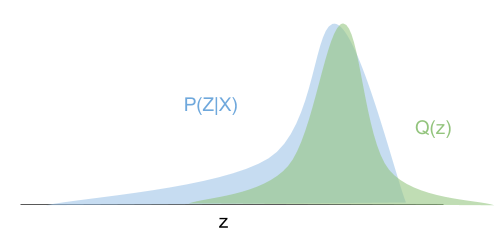

Image from Ashutosh Kushwaha's ["Variational Inference: Gaussian Mixture model"](https://ashkush.medium.com/variational-inference-gaussian-mixture-model-52595074247b) on Medium. 


Variational Inference (VI) methods frame approximation of intractable probability densities as a problem of optimization. VI tends to be faster than Markov Chain Monte Carlo (MCMC) methods, but sometimes at the cost of precision.

Today, we will explore how variational inference differs from MCMC when the posterior distribution's variables covary. Much like last week, we will be performing linear regression.

First, we need to import our packages and create our training dataset.

In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

**Fill in the number of data points below.** Keep this number $\leq 50$ for ideal visualization.

In [19]:
# Number of datapoints
n = 50

# evenly spaced features
x_train = torch.linspace(0,1,n)

# design matrix
Phi = torch.vstack((torch.ones(n),x_train)).T

# "true" parameter values
W_true = torch.ones(2,1)

# Observational noise
sigma2_obs = 1e-2

# Compute the true y and corrupt with noise
y_true = Phi @ W_true
noise = torch.randn(n,1)*np.sqrt(sigma2_obs)
y_train = y_true + noise

Let's visualize our training data.

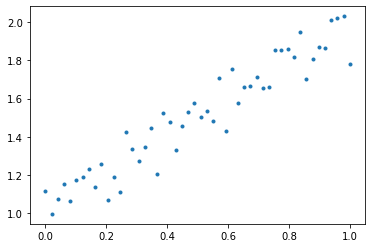

In [20]:
plt.plot(x_train,y_train,'.')

In our paper's overview of variational inference, we learned that we could optimize our approximation of the posterior by specifying a family of densities $\mathcal{Q}$ over the latent variables and finding some $q^* (\mathbf{z})$ that is closest in KL divergence to the posterior. 

We also found that the KL divergence could be manipulated to look like 


$$
\text{KL}(q(z) || p(z|x)) = \log p(x) - \int q(z) \log \frac{p(x,z)}{q(z)} dz,
$$

and that maximizing the second term, the Evidence Lower Bound, was all we needed to do to minimize this divergence.

Let's specify the prior distributions for our two model parameters, our slope and intercept. In this case, it would be a good choice to provide a vague prior, which will play a very minor role in influencing the posterior distribution.

A good choice for a diffuse prior would be mean $\mu = 0$ and a large variance (e.g. somewhere near 100).

In [21]:
# Specify priors
mu_prior = torch.zeros(2,1) # mean is defined here...
sigma2_prior = torch.ones(2,1)
sigma2_prior.data[:]*=100.0 # variance is defined here...

Now, let's make sure these look right.

In [22]:
mu_prior

tensor([[0.],
        [0.]])

In [23]:
sigma2_prior

tensor([[100.],
        [100.]])

Next we'll initialize the parameters of our variational distribution.  

Recall from the paper that we will be using mean-field variational inference, where each latent variable is independent and therefore has its own density. The generic form of the mean-field variational family is

$$
q(\mathbf{z}) = \prod_{j=1}^m q_j (z_j).
$$


In our case, we will assume the mean-field approximation over both the slope and intercept with a normal variational posterior with learnable mean and standard deviation

$$
q(\mathbf{w}) = \mathcal{N}(w_0;\mu_0,\sigma_0) \mathcal{N}(w_1;\mu_1,\sigma_1).
$$

Note the parameterization in terms of standard deviation instead of variance.  This avoids having to explicitly constrain the variable to be positive.


In [24]:
mu_post = torch.rand(2,1,requires_grad=True)
sigma_post = torch.rand(2,1,requires_grad=True)

We will optimize the loss

$$
L = \frac{1}{m} \sum_{j=1}^m \log P(\mathbf{y}_{obs} | \mathbf{x}_{obs}, \mathbf{w}_j) + KL(q(\mathbf{w}) || p(\mathbf{w}) ),
$$

with $\mathbf{w}_j \sim q(\mathbf{w})$ and $p(\mathbf{w})$ the prior defined above.  Thus we need a log-likelihood and a function that computes the (analytical) KL distribution between two diagonal normals.  



In [25]:
def log_likelihood(y_pred,y_obs,sigma2_obs):
    # TODO: Based on arguments, how would you calculate log likelihood?
    return n/2*np.sqrt(2*np.pi*sigma2_obs) + 0.5/sigma2_obs*torch.sum((y_pred - y_obs)**2)


def kl_gaussian_diagonal(mu_post,mu_prior,sigma2_post,sigma2_prior):
    k = len(mu_post)
    log_det_ratio = torch.log(sigma2_prior).sum() - torch.log(sigma2_post).sum()
    sse = torch.sum((mu_post - mu_prior)**2/sigma2_prior)
    trace = (sigma2_post/sigma2_prior).sum()
    return 0.5*(log_det_ratio - k + sse + trace)

![KL](KL.png)

Now we can perform a training loop with simple stochastic gradient descent. **Below, fill in the number of iterations and samples.** The number of samples is small.

Text(0, 0.5, 'loss')

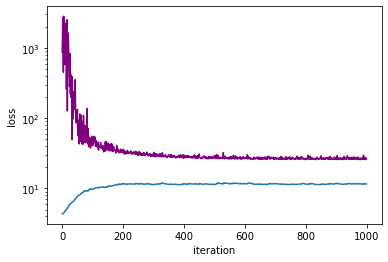

In [26]:
n_iterations = 1000

# Number of likelihood evaluations for MC-approximation to data loss
n_samples = 4

# step size (this is annoying to tune: better to use ADAM)
eta = 1e-5

data_losses = []
kl_losses = []

# training loop
for i in range(n_iterations):
  

    # Compute data loss
    L_data = 0
    for j in range(n_samples):
        # Sample parameters
        W = mu_post + torch.randn(2,1)*sigma_post
        
        # Compute forward model
        y_pred = Phi @ W
        
        # Update data loss
        L_data = L_data + (1/n_samples) * log_likelihood(y_pred,y_train,sigma2_obs)#TODO: What calculation goes after the "*"? 
    
    
    # Compute KL-loss (prior)
    L_kl = kl_gaussian_diagonal(mu_post,mu_prior,sigma_post**2,sigma2_prior)
    
    L = L_data + L_kl
    L.backward()
    
    data_losses.append(L_data.detach())
    kl_losses.append(L_kl.detach())
    
    # Gradient descent
    with torch.no_grad():
        # For below, dont forget about the `.grad` attribute on torch tensors
        mu_post -= eta*mu_post.grad
        sigma_post -= eta*sigma_post.grad
    mu_post.grad = None # This is supposed to be None! Don't change
    sigma_post.grad = None # This is supposed to be None! Don't change
    
# Plot convergence 
plt.semilogy(data_losses, color='purple')
plt.semilogy(kl_losses)
plt.xlabel('iteration')
plt.ylabel('loss')

If all went well, we will see the data loss decrease. 

We can use Bayesian linear regression to get an analytical solution for both the posterior mean and the (full) covariance matrix. We can use this to see how well we did in our approximation.

In [27]:
# Posterior precision
Sigma_inv = 1./sigma2_obs*Phi.T @ Phi + torch.diag(1./sigma2_prior)

# Posterior covariance
Sigma = torch.linalg.inv(Sigma_inv)

# Posterior cholesky decomp (matrix square root)
L = torch.linalg.cholesky(Sigma)

# Posterior mean
mu_analytical = 1./sigma2_obs * Sigma @ Phi.T @ y_train

In [28]:
print(mu_post,sigma_post)
print(mu_analytical)

tensor([[1.0428],
        [0.9361]], requires_grad=True) tensor([[0.0146],
        [0.0243]], requires_grad=True)
tensor([[1.0360],
        [0.9464]])


We can visualize both the posterior predictive distribution (the set of lines that are consistent with the data) as well as the posterior distribution (the slope and intercept samples).

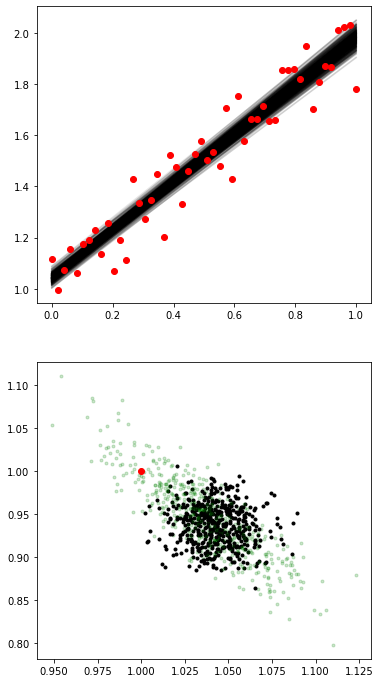

In [29]:
with torch.no_grad():
    # Number of posterior samples to draw
    n_plots = 500
    fig,axs = plt.subplots(nrows=2)
    w_0_samples = []
    w_1_samples = []
    for i in range(n_plots):
        # Random sample from variational posterior
        W = mu_post + torch.randn(2,1)*sigma_post
        y_pred = Phi @ W 
        # Plot predictive
        axs[0].plot(x_train,y_pred.detach(),'k-',alpha=0.1)
        # Plot parameters
        axs[1].plot(W[0],W[1],'k.')
        w_0_samples.append([W[0].item(),W[1].item()])
        # Bonus plot: samples drawn from the analytical posterior
        W_analytical = mu_analytical + L @ torch.randn(2,1)
        axs[1].plot(W_analytical[0],W_analytical[1],'g.',alpha=0.2)
        w_1_samples.append([W_analytical[0].item(),W_analytical[1].item()])
        
    # Plot data/true values
    axs[0].plot(x_train, y_train,'ro')
    axs[1].plot(W_true[0], W_true[1],'ro')
    

    
fig.set_size_inches(6,12)

**What are the x and y axes of each plot above?**

Here is another way to view our distribution of samples.

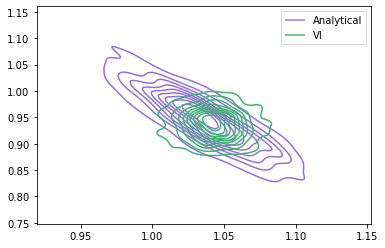

In [30]:
w_0_samples = np.array(w_0_samples)
w_1_samples = np.array(w_1_samples)

sns.kdeplot(x=w_1_samples[:,0], y=w_1_samples[:,1], label="Analytical", color="mediumpurple")
sns.kdeplot(x=w_0_samples[:,0], y=w_0_samples[:,1],label="VI", color="mediumseagreen")
plt.legend()
plt.show()

Take a look at Figure 1 of the [Variational Inference paper](https://arxiv.org/pdf/1601.00670.pdf), page 9. **What is at play here? In other words, why do these distributions look so different?**


The analytical solution shows a bit of interdependence between the variables, while the mean field approximation (the circular part) assumes complete independence.

## Markov Chain Monte Carlo

A key takeaway from Variational Inference is that its an alternative approach to making discoveries about a distrubtion that is less expensive than MCMC, but also less accurate. The paper's authors briefly explain scenarios that may be suited for one over the other. Let's see this point in practice, and make an apples-to-apples comparison of the two approaches on this Bayesian Linear Regression problem. For this comparison, we will be using Metropolis-Hastings, but feel free to use Hybrid Monte Carlo if you're so inclined. 


Import your MCMC implementation from last week's notebook, or if you prefer, key functionality for MH is imported for you below.

In [36]:
from utils import likelihood, prior, posterior, mh, gen_coeffs, coeff_plot

betas = mh(torch.Tensor.numpy(x_train), torch.Tensor.numpy(y_train), order=1, steps=10000)

Use your MCMC code to generate a predictive posterior distribution on `x_train` and `y_train`, and compare with the posterior distibution (as we did with VI). 

Compare runtimes of MCMC vs VI. What do you notice?


*Runtime is a lot slower, but that makes sense given the architecture.*

In [56]:
# TODO: Run MCMC!
# TODO: Runtime comparison


Generate charts to compare MCMC to *both* the VI and Analytical distributions (as done in the KDE chart above). Qualitatively, what do you notice about the MCMC goodness-of-fit compared to that of VI?


*I think I did something wrong.......*

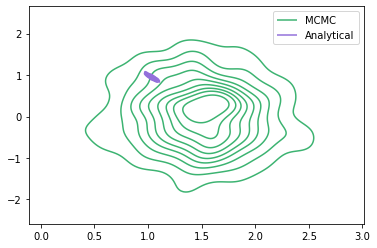

In [37]:
betas_tensor = torch.tensor(np.array(betas))
mcc_mean = betas_tensor.mean(axis=0).reshape(2,1)
mcc_std = betas_tensor.std(axis=0).reshape(2,1)

with torch.no_grad():
    n_plots = 500
    mcc_samples = []
    
    for i in range(n_plots):
        W = mcc_mean + mcc_std*torch.randn(2,1)
        mcc_samples.append([W[0].item(),W[1].item()])
        
mcc_samples = torch.tensor(mcc_samples)
sns.kdeplot(x=mcc_samples[:,0], y=mcc_samples[:,1],label="MCMC", color="mediumseagreen")
sns.kdeplot(x=w_1_samples[:,0], y=w_1_samples[:,1],label="Analytical", color="mediumpurple")
plt.legend()
plt.show()

With these discrepancies in mind, as a ML practitioner, what would you say about choosing VI or MCMC  for a problem such as this one? What are important considerations? Give a real-world example where VI would be a better choice. Do the same for MCMC.


*VI lends itself to handling large datasets and usage of multiple models quickly, while MCMC is great for small datasets where you might want more detail at the cost of higher computational requirements. So scope of what you want to do and the computational resources available are major considerations. Real world examples might be using VI to model based of national data (for COVID or something similar) while using MCMC for something like at the county level.*